### **ICU Patient Outcomes – Model Evaluation & Deployment**

---

**Overview**

This notebook represents the final stage of the ICU analytics pipeline and builds on the work completed in the **ICU_EDA**, **ICU_Data_Preparation**, and **ICU_Modeling** notebooks. The purpose of this final phase is to extend the evaluation of the selected models and demonstrate a simplified deployment workflow suitable for instructional and simulation-based use.

From the prior modeling analyses, the **Logistic Regression mortality model** emerged as the strongest candidate for deployment. Its robust performance, high interpretability, and alignment with clinical decision-making make it well-suited for early risk stratification and quality-improvement initiatives within the ICU. Accordingly, this notebook places primary emphasis on refining, validating, and preparing this model for downstream use.

The **ICU Length-of-Stay Random Forest model** and the **K-Means clustering analysis** provide complementary operational insights. LOS forecasting supports bed-flow and staffing decisions, while clustering contributes to capacity planning and patient-flow optimization. These models are included in a supporting role to illustrate how they enhance a multi-model decision-support framework addressing both clinical and administrative objectives.

This notebook is organized into two major components:

- **Extended Model Evaluation:**  
   - This section deepens the evaluation of the selected models through calibration curves, threshold exploration, fairness checks, error profiling, and stability assessments. The primary focus is on the Logistic Regression mortality model, ensuring it is reliable and interpretable. Supporting evaluations for the LOS forecasting model and clustering analysis are included to reaffirm their operational value.

- **Model Deployment:**  
    - This section demonstrates a lightweight, simulation-oriented deployment process. It shows how the finalized model can be saved, reloaded in a clean environment, and used to generate predictions for new patient data. The goal is to illustrate the core concepts behind model deployment.

By the end of this notebook, the mortality prediction model will be thoroughly evaluated, validated, and packaged for simulated deployment - completing the CRISP-DM workflow for this project and establishing a clear foundation for actionable decision support within the ICU.

---

### **Step 0: Import Modules**
The initial code block imports all Python libraries used for this notebook. These include packages required for advanced model evaluation, calibration, interpretability, and deployment, as well as core libraries for data manipulation, scikit-learn modules for metrics and model export, visualization tools for diagnostic plots, and utilities.

In [14]:
# Core
import os
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import joblib

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modeling utilities
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.calibration import calibration_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans

# Metrics & Evaluation
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay,
    silhouette_score, brier_score_loss
)

# Configuration
pd.set_option("display.max_columns", 120)
random_state = 42
np.random.seed(random_state)

### **Step 1: Load Data**

---

**Overview**

This step loads the analytic dataset. Importantly, **the dataset represents one row per hospital admission** and includes key features such as patient demographics, ICU exposure, comorbidities, and outcomes.

---

**Process summary:**

- Define file path and import the analytic dataset  
- Inspect dataset shape and column structure  
- Display a small sample of rows for visual confirmation  

In [15]:
# File path
data_path = "analytic_admissions_dataset.csv"

# Load dataset
df = pd.read_csv(data_path, low_memory=False)

# Basic info
print(f"Shape: {df.shape}")
print("\n--- Column Info ---")
df.info()

# Quick look at first few rows
display(df.head())

Shape: (275, 38)

--- Column Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subject_id              275 non-null    int64  
 1   hadm_id                 275 non-null    int64  
 2   admittime               275 non-null    object 
 3   dischtime               275 non-null    object 
 4   deathtime               15 non-null     object 
 5   hospital_expire_flag    275 non-null    int64  
 6   hospital_los_days       275 non-null    float64
 7   readmit_30d_flag        275 non-null    int64  
 8   weekend_admit_flag      275 non-null    int64  
 9   gender                  275 non-null    object 
 10  anchor_age              275 non-null    int64  
 11  age_group               275 non-null    object 
 12  anchor_year             275 non-null    int64  
 13  anchor_year_group       275 non-null    object 
 14  dod 

,subject_id,hadm_id,admittime,dischtime,deathtime,hospital_expire_flag,hospital_los_days,readmit_30d_flag,weekend_admit_flag,gender,anchor_age,age_group,anchor_year,anchor_year_group,dod,ever_in_icu_flag,n_icustays,icu_total_los_days,icu_first_in,icu_last_out,icu_any_multiunit,n_transfers,n_icu_transfers,any_icu_transfer,n_unique_careunits,num_dx,num_icd9,num_icd10,primary_icd_code,primary_icd_version,primary_icd_long_title,admission_type,admission_location,discharge_location,insurance,language,marital_status,race
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,0,0.79,0,1,F,52,40-64,2180,2014 - 2016,2180-09-09,0,NaN,NaN,NaN,NaN,NaN,3,0,0,3,8,8,0,5723,9,Portal hypertension,Urgent,Transfer From Hospital,Home,Other,English,Widowed,White
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,0,1.02,1,0,F,52,40-64,2180,2014 - 2016,2180-09-09,0,NaN,NaN,NaN,NaN,NaN,3,0,0,3,8,8,0,7071,9,NaN,Ew Emer.,Emergency Room,Home,Medicaid,English,Widowed,White
2,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,0,2.22,1,1,F,52,40-64,2180,2014 - 2016,2180-09-09,1,1.0,0.410266,2180-07-23 14:00:00,2180-07-23 23:50:47,0.0,6,1,1,4,13,13,0,45829,9,Other iatrogenic hypotension,Ew Emer.,Emergency Room,Home,Medicaid,English,Widowed,White
3,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,0,1.75,0,1,F,52,40-64,2180,2014 - 2016,2180-09-09,0,NaN,NaN,NaN,NaN,NaN,3,0,0,3,10,10,0,7054,9,NaN,Ew Emer.,Emergency Room,Hospice,Medicaid,English,Widowed,White
4,10001217,24597018,2157-11-18 22:56:00,2157-11-25 18:00:00,NaN,0,6.79,1,0,F,55,40-64,2157,2011 - 2013,NaN,1,1.0,1.118032,2157-11-20 19:18:02,2157-11-21 22:08:00,0.0,6,1,1,5,10,10,0,3240,9,Intracranial abscess,Ew Emer.,Emergency Room,Home Health Care,Other,?,Married,White


### **Step 2: Load Trained Models**

---

**Overview**

In this step, we load the finalized models exported from the **ICU_Modeling** notebook. These serialized model objects will be used for extended evaluation and for demonstrating a simplified deployment workflow.

The primary focus is the **Logistic Regression mortality model**, which was selected as the deployment candidate. The **ICU Length-of-Stay Random Forest model** and the **K-Means clustering model** are also loaded to support additional evaluation and operational analysis.

---

**Process summary:**

- Load each serialized model using `joblib.load()`  
- Store the models for further evaluation and deployment steps

In [16]:
for file in ["mortality_logreg.pkl", "los_random_forest.pkl", "kmeans_clusters.pkl"]:
    if not Path(file).exists():
        print(f"WARNING: {file} not found!")

mortality_model = joblib.load("mortality_logreg.pkl")
los_model = joblib.load("los_random_forest.pkl")
cluster_model = joblib.load("kmeans_clusters.pkl")

### **Step 3: Extended Evaluation – Mortality Prediction Model**

---

**Overview**

In this step, we conduct an extended evaluation of the **Logistic Regression mortality model**, the primary model selected for deployment. While the initial modeling notebook provided a baseline assessment, this phase deepens the evaluation through additional performance checks, calibration analysis, threshold exploration, and error profiling.

This extended evaluation ensures that the final model is not only accurate, but also interpretable, stable, and aligned with clinical decision-support needs.

---

**Process summary:**

- Extract features and target from the analytic dataset  
- Generate predictions and predicted probabilities  
- Evaluate overall model performance  
- Plot ROC and Precision-Recall curves  
- Assess calibration of predicted probabilities  
- Explore decision thresholds  
- Profile model errors and misclassifications  

In [17]:
# --- Step 3.1: Prepare Feature Matrix and Target Vector ---

# Columns that were removed during modeling (IDs, timestamps, anchors, and text fields)
drop_cols = [
    "subject_id", "hadm_id", "admittime", "dischtime", "deathtime",
    "anchor_year", "anchor_year_group", "dod",
    "primary_icd_code", "primary_icd_version", "primary_icd_long_title",
    "icu_first_in", "icu_last_out"
]

# Define target variables (same as in ICU_Modeling)
target_los = "icu_total_los_days"
target_readmit = "readmit_30d_flag"
target_mortality = "hospital_expire_flag"

# Recreate df_model used in the modeling notebook
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()

# Filter for valid mortality records
df_mort = df_model[df_model[target_mortality].notna()].copy()
print(f"Valid admissions for mortality modeling: {df_mort.shape[0]} rows")

# Features = all columns except the target variables
X_mort = df_mort.drop(columns=[target_los, target_readmit, target_mortality])
y_mort = df_mort[target_mortality]

print("Features and target extracted successfully.")
print(f"X_mort shape: {X_mort.shape}")
print(f"y_mort distribution:\n{y_mort.value_counts()}")

Valid admissions for mortality modeling: 275 rows
Features and target extracted successfully.
X_mort shape: (275, 22)
y_mort distribution:
hospital_expire_flag
0    260
1     15
Name: count, dtype: int64


In [18]:
# --- Step 3.2: Generate Predictions and Compute Basic Metrics ---

# Predicted classes (0/1)
y_pred = mortality_model.predict(X_mort)

# Predicted probabilities for the positive class (mortality = 1)
y_prob = mortality_model.predict_proba(X_mort)[:, 1]

# Compute metrics
accuracy = accuracy_score(y_mort, y_pred)
precision = precision_score(y_mort, y_pred)
recall = recall_score(y_mort, y_pred)
f1 = f1_score(y_mort, y_pred)
roc_auc = roc_auc_score(y_mort, y_prob)

# Print summary
print("=== Mortality Model: Basic Performance Metrics ===")
print(f"Accuracy:      {accuracy:.3f}")
print(f"Precision:     {precision:.3f}")
print(f"Recall:        {recall:.3f}")
print(f"F1 Score:      {f1:.3f}")
print(f"ROC-AUC:       {roc_auc:.3f}")

=== Mortality Model: Basic Performance Metrics ===
Accuracy:      0.985
Precision:     0.824
Recall:        0.933
F1 Score:      0.875
ROC-AUC:       0.999


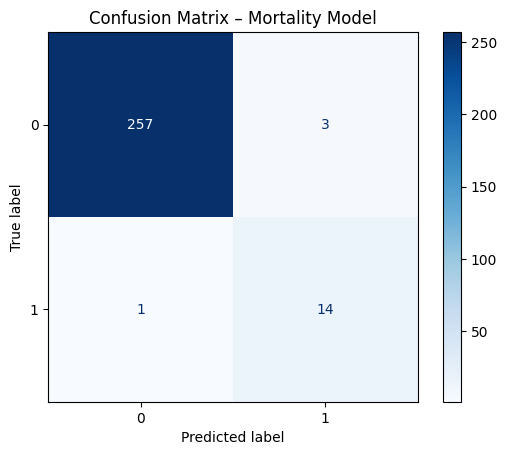

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       260
           1       0.82      0.93      0.88        15

    accuracy                           0.99       275
   macro avg       0.91      0.96      0.93       275
weighted avg       0.99      0.99      0.99       275



In [19]:
# --- Step 3.3: Confusion Matrix & Classification Report ---

# Confusion matrix
cm = confusion_matrix(y_mort, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Mortality Model")
plt.show()

# Classification report
print("=== Classification Report ===")
print(classification_report(y_mort, y_pred))

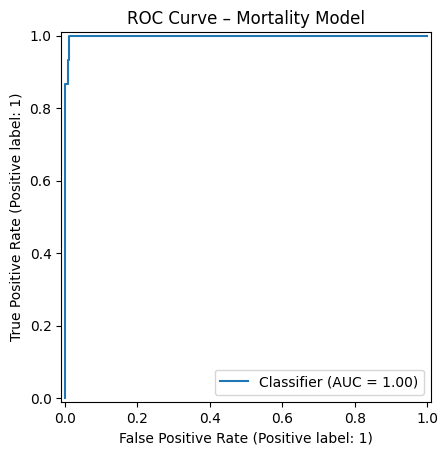

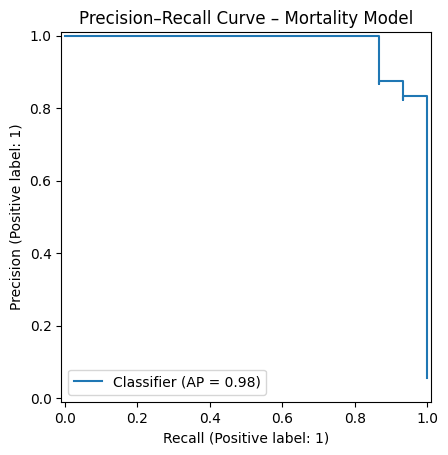

In [20]:
# --- Step 3.4: ROC Curve and Precision–Recall Curve ---

# ROC curve
RocCurveDisplay.from_predictions(y_mort, y_prob)
plt.title("ROC Curve – Mortality Model")
plt.show()

# Precision–Recall curve
PrecisionRecallDisplay.from_predictions(y_mort, y_prob)
plt.title("Precision–Recall Curve – Mortality Model")
plt.show()

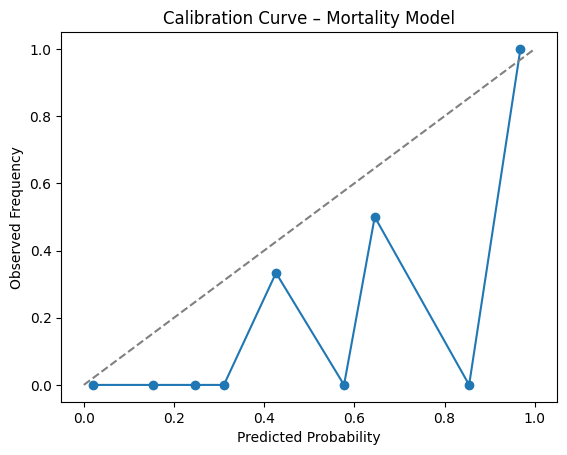

Brier Score: 0.0126


In [21]:
# --- Step 3.5: Calibration Curve & Brier Score ---

# Calibration curve
prob_true, prob_pred = calibration_curve(y_mort, y_prob, n_bins=10, strategy="uniform")

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve – Mortality Model")
plt.show()

# Brier score
brier = brier_score_loss(y_mort, y_prob)
print(f"Brier Score: {brier:.4f}")

In [22]:
# --- Step 3.6: Threshold Tuning ---

thresholds = np.arange(0.1, 0.91, 0.05)

results = []

for t in thresholds:
    preds_t = (y_prob >= t).astype(int)
    prec = precision_score(y_mort, preds_t)
    rec = recall_score(y_mort, preds_t)
    f1_t = f1_score(y_mort, preds_t)
    results.append([t, prec, rec, f1_t])

threshold_df = pd.DataFrame(results, columns=["threshold", "precision", "recall", "f1"])
threshold_df

,threshold,precision,recall,f1
0,0.10,0.340909,1.000000,0.508475
1,0.15,0.384615,1.000000,0.555556
2,0.20,0.517241,1.000000,0.681818
3,0.25,0.576923,1.000000,0.731707
4,0.30,0.652174,1.000000,0.789474
5,0.35,0.750000,1.000000,0.857143
6,0.40,0.750000,1.000000,0.857143
7,0.45,0.833333,1.000000,0.909091
8,0.50,0.823529,0.933333,0.875000
9,0.55,0.823529,0.933333,0.875000


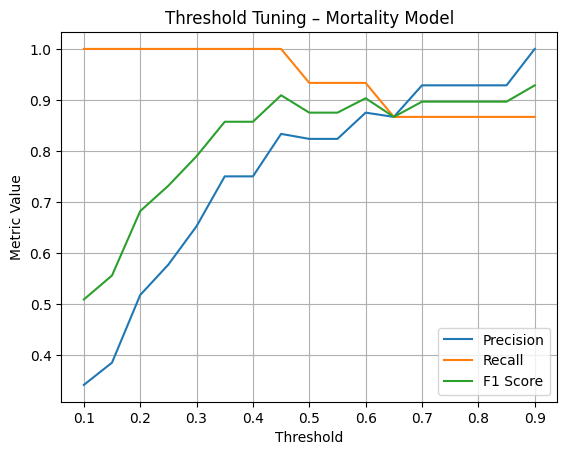

In [23]:
plt.plot(threshold_df["threshold"], threshold_df["precision"], label="Precision")
plt.plot(threshold_df["threshold"], threshold_df["recall"], label="Recall")
plt.plot(threshold_df["threshold"], threshold_df["f1"], label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Threshold Tuning – Mortality Model")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# --- Step 3.7: Error Profiling ---

# Add predictions to the dataset
df_mort_eval = df_mort.copy()
df_mort_eval["y_pred"] = y_pred
df_mort_eval["y_prob"] = y_prob

# Define error categories
df_mort_eval["error_type"] = np.where(
    (y_mort == 1) & (y_pred == 1), "True Positive",
    np.where((y_mort == 0) & (y_pred == 0), "True Negative",
    np.where((y_mort == 0) & (y_pred == 1), "False Positive", "False Negative"))
)

# Display counts
df_mort_eval["error_type"].value_counts()

error_type
True Negative     257
True Positive      14
False Positive      3
False Negative      1
Name: count, dtype: int64

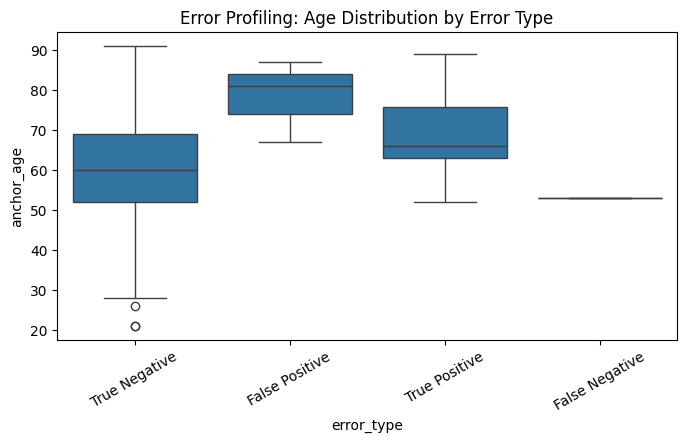

In [25]:
# Compare age distribution by error type
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_mort_eval, x="error_type", y="anchor_age")
plt.title("Error Profiling: Age Distribution by Error Type")
plt.xticks(rotation=30)
plt.show()

Numeric features used by model:
['hospital_los_days', 'weekend_admit_flag', 'anchor_age', 'ever_in_icu_flag', 'n_icustays', 'icu_any_multiunit', 'n_transfers', 'n_icu_transfers', 'any_icu_transfer', 'n_unique_careunits', 'num_dx', 'num_icd9', 'num_icd10']

Categorical features used by model:
['gender', 'age_group', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race']


,feature,coefficient,odds_ratio
41,discharge_location_Died,2.593022,13.370111
10,num_dx,0.952044,2.591000
3,ever_in_icu_flag,0.721157,2.056812
4,n_icustays,0.649303,1.914205
12,num_icd10,0.539038,1.714357
54,marital_status_Married,0.437011,1.548074
8,any_icu_transfer,0.308211,1.360988
5,icu_any_multiunit,0.280556,1.323866
2,anchor_age,0.269269,1.309007
11,num_icd9,0.267422,1.306592


,feature,coefficient,odds_ratio
57,marital_status_Widowed,-0.441585,0.643017
50,insurance_Other,-0.463739,0.628928
58,race_Black/African American,-0.487902,0.613913
13,gender_F,-0.540649,0.582370
0,hospital_los_days,-0.629419,0.532902
16,age_group_40-64,-0.655559,0.519152
42,discharge_location_Home,-0.662361,0.515632
52,language_English,-0.912345,0.401581
43,discharge_location_Home Health Care,-0.934268,0.392873
46,discharge_location_Skilled Nursing Facility,-0.966588,0.380379


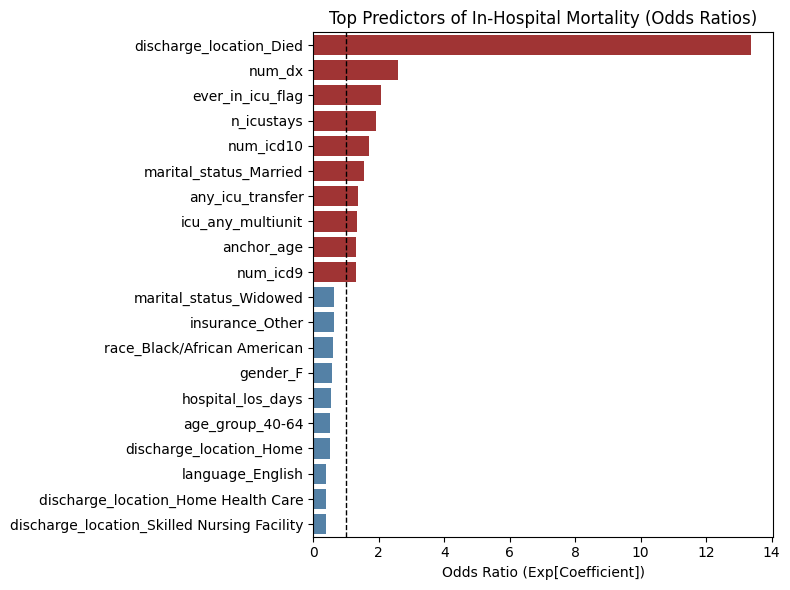

In [26]:
# --- Step 3.8: Extract and interpret mortality model coefficients ---

# Unpack preprocessor and logistic regression model from the saved pipeline
preprocessor = mortality_model.named_steps["preprocessor"]
log_model = mortality_model.named_steps["model"]

# Recover numeric and categorical feature lists from the ColumnTransformer
numeric_features = []
categorical_features = []

for name, transformer, cols in preprocessor.transformers_:
    if name == "num":
        numeric_features = list(cols)
    elif name == "cat":
        categorical_features = list(cols)

print("Numeric features used by model:")
print(numeric_features)
print("\nCategorical features used by model:")
print(categorical_features)

# Get encoded categorical feature names from the encoder
encoder = preprocessor.named_transformers_["cat"].named_steps["encoder"]
cat_feature_names = encoder.get_feature_names_out(categorical_features)

# Combine numeric and encoded categorical feature names
all_features = numeric_features + list(cat_feature_names)

# Build dataframe of coefficients
coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": log_model.coef_[0]
})
coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])
coef_df = coef_df.sort_values("odds_ratio", ascending=False)

# Display top and bottom predictors
display(coef_df.head(10))
display(coef_df.tail(10))

# --- Plot top positive and negative predictors ---
top_features = pd.concat([coef_df.head(10), coef_df.tail(10)])

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_features,
    x="odds_ratio",
    y="feature",
    palette=["firebrick" if x > 1 else "steelblue" for x in top_features["odds_ratio"]]
)
plt.axvline(1, color="black", linestyle="--", linewidth=1)
plt.title("Top Predictors of In-Hospital Mortality (Odds Ratios)")
plt.xlabel("Odds Ratio (Exp[Coefficient])")
plt.ylabel("")
plt.tight_layout()
plt.show()

### **Step 4: Extended Evaluation – ICU Length-of-Stay (LOS) Model**

---

**Overview**

In this step, we perform a focused evaluation of the ICU Length-of-Stay (LOS) Random Forest model. While this model was not selected as the primary deployment target, LOS forecasting plays an important operational role by supporting ICU bed planning, resource allocation, and staffing decisions.

The goal of this section is to reproduce the key performance metrics from the modeling notebook, assess prediction error patterns, and visualize residual behavior to better understand where the model tends to over- or under-estimate ICU LOS.

---

**Process summary:**

- Reconstruct the LOS modeling dataset  
- Generate LOS predictions  
- Compute regression metrics (MAE, RMSE, R²)  
- Visualize prediction vs. actual values  
- Examine residual distributions and error patterns

In [27]:
# --- Step 4.1: Prepare Feature Matrix and Target Vector (LOS) ---

# Target variable
target_los = "icu_total_los_days"

# Drop the same non-feature columns as in mortality modeling
df_los = df_model[df_model[target_los].notna()].copy()

# Features = all non-target columns (excluding other targets)
X_los = df_los.drop(columns=[target_los, target_readmit, target_mortality])
y_los = df_los[target_los]

print("LOS feature matrix and target prepared successfully.")
print(f"X_los shape: {X_los.shape}")
print(f"y_los summary:\n{y_los.describe()}")

LOS feature matrix and target prepared successfully.
X_los shape: (128, 22)
y_los summary:
count    128.000000
mean       4.024321
std        4.439222
min        0.155949
25%        1.184201
50%        2.159595
75%        4.907749
max       20.528681
Name: icu_total_los_days, dtype: float64


In [29]:
# --- Step 4.2: Generate Predictions & Compute Regression Metrics ---

# Predictions
los_pred = los_model.predict(X_los)

# Metrics
mae = mean_absolute_error(y_los, los_pred)
rmse = mean_squared_error(y_los, los_pred, squared=False)
r2 = r2_score(y_los, los_pred)

print("=== LOS Model: Basic Performance Metrics ===")
print(f"MAE:   {mae:.3f}")
print(f"RMSE:  {rmse:.3f}")
print(f"R²:    {r2:.3f}")

=== LOS Model: Basic Performance Metrics ===
MAE:   1.380
RMSE:  2.300
R²:    0.729


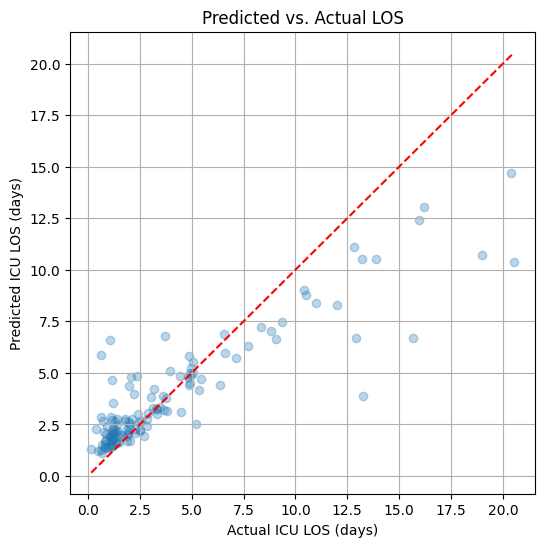

In [30]:
# --- Step 4.3: Predicted vs. Actual LOS ---

plt.figure(figsize=(6, 6))
plt.scatter(y_los, los_pred, alpha=0.3)
plt.plot([y_los.min(), y_los.max()], [y_los.min(), y_los.max()], 'r--')

plt.xlabel("Actual ICU LOS (days)")
plt.ylabel("Predicted ICU LOS (days)")
plt.title("Predicted vs. Actual LOS")
plt.grid(True)
plt.show()

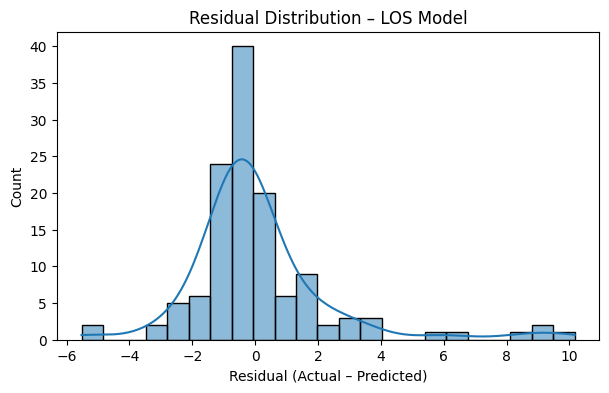

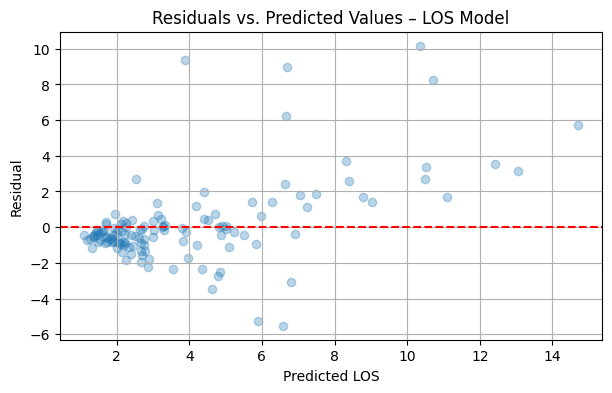

In [31]:
# --- Step 4.4: Residual Analysis ---

residuals = y_los - los_pred

plt.figure(figsize=(7, 4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution – LOS Model")
plt.xlabel("Residual (Actual – Predicted)")
plt.ylabel("Count")
plt.show()

# Residuals vs. predicted
plt.figure(figsize=(7, 4))
plt.scatter(los_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted LOS")
plt.ylabel("Residual")
plt.title("Residuals vs. Predicted Values – LOS Model")
plt.grid(True)
plt.show()

### **Step 5: Extended Evaluation – Clustering Model**

---

**Overview**

In this step, we evaluate the K-Means clustering model developed during the ICU_Modeling phase. The clustering model serves a complementary operational role by identifying groups of patient admissions with similar clinical or resource-utilization patterns. These insights can support ICU capacity planning, resource optimization, and identification of distinct patient subgroups.

The goal of this section is to reproduce the preprocessing applied during the modeling workflow, assign cluster labels using the saved clustering pipeline, assess cluster coherence, and explore cluster characteristics through descriptive summaries and visualizations.

---

**Process summary:**

- Reconstruct the clustering feature matrix  
- Apply the saved K-Means pipeline to generate cluster assignments  
- Evaluate overall coherence using silhouette score  
- Examine cluster sizes and composition  
- Visualize clusters using PCA for dimensionality reduction  
- Profile clusters using key clinical and operational variables

In [32]:
# --- Step 5.1: Prepare Clustering Feature Matrix ---

cluster_features = [
    "hospital_los_days", "ever_in_icu_flag", "n_icustays", "icu_total_los_days",
    "n_transfers", "n_icu_transfers", "any_icu_transfer", "n_unique_careunits",
    "num_dx", "num_icd9", "num_icd10"
]

# Filter rows with complete data
df_cluster = df[cluster_features].dropna().copy()
X_cluster = df_cluster.copy()

print("Clustering feature matrix prepared.")
print(f"Shape: {X_cluster.shape}")

Clustering feature matrix prepared.
Shape: (128, 11)


In [33]:
# --- Step 5.2: Apply Saved Clustering Pipeline ---

cluster_labels = cluster_model.predict(X_cluster)
df_cluster["cluster"] = cluster_labels

print("Cluster assignments generated successfully.")
df_cluster["cluster"].value_counts()

Cluster assignments generated successfully.


cluster
0    80
1    23
3    16
2     9
Name: count, dtype: int64

In [34]:
# --- Step 5.3: Silhouette Score ---

sil_score = silhouette_score(X_cluster, cluster_labels)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.272


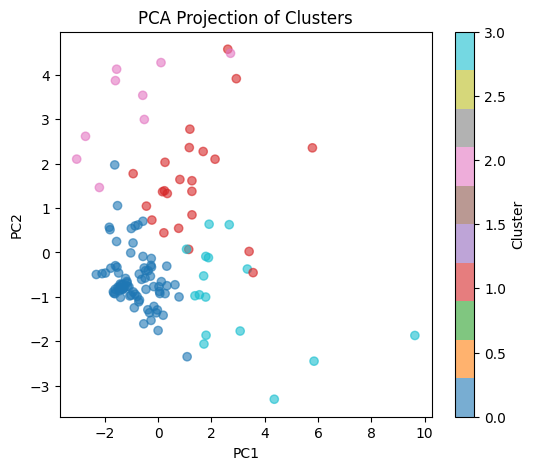

In [35]:
# --- Step 5.4: PCA Visualization of Clusters ---

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(cluster_model.named_steps["scaler"].transform(X_cluster))

plt.figure(figsize=(6, 5))
plt.scatter(components[:, 0], components[:, 1], c=cluster_labels, cmap="tab10", alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Clusters")
plt.colorbar(label="Cluster")
plt.show()

In [36]:
# --- Step 5.5: Cluster Profiling ---

cluster_summary = df_cluster.groupby("cluster").agg({
    "icu_total_los_days": ["mean", "median"],
    "num_dx": ["mean", "median"],
    "n_icustays": "mean",
    "n_icu_transfers": "mean",
    "n_unique_careunits": "mean"
})

cluster_summary

icu_total_los_days               num_dx        n_icustays  \
                      mean    median       mean median       mean   
cluster                                                             
0                 2.018941  1.561927  12.650000   11.5   1.012500   
1                 6.968626  4.909537  29.217391   28.0   1.086957   
2                 5.481992  4.907153  22.666667   26.0   1.111111   
3                 8.998841  8.717101  27.562500   29.5   1.500000   

        n_icu_transfers n_unique_careunits  
                   mean               mean  
cluster                                     
0              1.137500           3.950000  
1              1.478261           4.565217  
2              0.000000           3.555556  
3              1.875000           4.437500

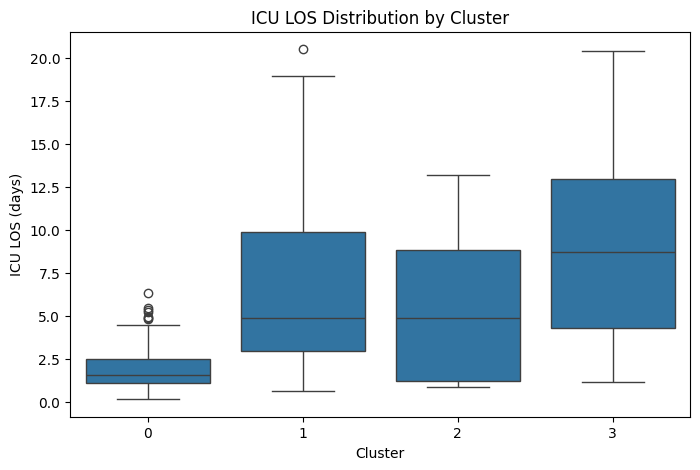

In [37]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cluster, x="cluster", y="icu_total_los_days")
plt.title("ICU LOS Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("ICU LOS (days)")
plt.show()

### **Step 6: Deployment Workflow**

---

**Overview**

In this final step, we demonstrate a simplified, simulation-oriented deployment workflow for the Logistic Regression mortality model. The goal is not to build a full production system, but to illustrate the key concepts involved in using a trained model for inference on new data.

We focus on three core ideas:

1. Defining the feature schema expected by the model  
2. Running single-admission and batch predictions  
3. (Optionally) exporting a deployment-ready model artifact  

All examples reuse the analytic dataset to simulate how predictions would be generated for new ICU admissions in practice.

---

**Process summary:**

- Capture the final feature set used by the mortality model  
- Implement a small helper function for inference  
- Demonstrate single-admission prediction  
- Demonstrate batch prediction for multiple admissions  
- Optionally, save a deployment-ready model file  

In [38]:
# --- Step 6.1: Define Feature Schema ---

# Use the columns from X_mort as the model's expected feature schema
mortality_feature_cols = X_mort.columns.tolist()

print("Mortality model feature schema:")
print(mortality_feature_cols)
print(f"\nNumber of features: {len(mortality_feature_cols)}")

Mortality model feature schema:
['hospital_los_days', 'weekend_admit_flag', 'gender', 'anchor_age', 'age_group', 'ever_in_icu_flag', 'n_icustays', 'icu_any_multiunit', 'n_transfers', 'n_icu_transfers', 'any_icu_transfer', 'n_unique_careunits', 'num_dx', 'num_icd9', 'num_icd10', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race']

Number of features: 22


In [39]:
# --- Step 6.2: Define Helper Function for Inference ---

def predict_mortality_risk(model, df_input, feature_cols):
    """
    Run mortality risk prediction for one or more admissions.

    Parameters
    ----------
    model : fitted scikit-learn Pipeline
        The trained mortality model (including preprocessing).
    df_input : pd.DataFrame
        Input dataframe containing at least the required feature columns.
    feature_cols : list of str
        Names of features expected by the model.

    Returns
    -------
    pd.DataFrame
        DataFrame with predicted class and predicted probability of mortality.
    """
    # Ensure required columns are present
    missing = [c for c in feature_cols if c not in df_input.columns]
    if missing:
        raise ValueError(f"Input data is missing required columns: {missing}")

    X_new = df_input[feature_cols]

    # Make predictions
    y_pred_new = model.predict(X_new)
    y_prob_new = model.predict_proba(X_new)[:, 1]

    result = df_input.copy()
    result["pred_mortality_flag"] = y_pred_new
    result["pred_mortality_prob"] = y_prob_new

    return result

In [40]:
# --- Step 6.3: Single-Admission Prediction Example ---

# Simulate a "new" ICU admission by sampling one row
new_admission = df_mort.sample(1, random_state=random_state)

print("Example admission (input features):")
display(new_admission[mortality_feature_cols])

# Run inference
single_pred = predict_mortality_risk(
    model=mortality_model,
    df_input=new_admission,
    feature_cols=mortality_feature_cols
)

print("Predicted mortality risk for this admission:")
display(single_pred[["pred_mortality_flag", "pred_mortality_prob"]])

Example admission (input features):


,hospital_los_days,weekend_admit_flag,gender,anchor_age,age_group,ever_in_icu_flag,n_icustays,icu_any_multiunit,n_transfers,n_icu_transfers,any_icu_transfer,n_unique_careunits,num_dx,num_icd9,num_icd10,admission_type,admission_location,discharge_location,insurance,language,marital_status,race
30,6.05,1,F,72,65-79,0,NaN,NaN,5,0,0,4,29,29,0,Ew Emer.,Emergency Room,Skilled Nursing Facility,Medicare,English,Married,Black/African American


Predicted mortality risk for this admission:


,pred_mortality_flag,pred_mortality_prob
30,0,0.019395


In [41]:
# --- Step 6.4: Batch Prediction Example ---

# Simulate a batch of new admissions (e.g., next 10 ICU patients)
batch_admissions = df_mort.sample(10, random_state=random_state).copy()

batch_preds = predict_mortality_risk(
    model=mortality_model,
    df_input=batch_admissions,
    feature_cols=mortality_feature_cols
)

# Show a subset of columns for readability
cols_to_show = [
    "hospital_los_days", "ever_in_icu_flag", "n_icustays",
    "age_group", "gender", "race",
    "pred_mortality_flag", "pred_mortality_prob"
]

existing_cols_to_show = [c for c in cols_to_show if c in batch_preds.columns]

print("Batch prediction results (sample of columns):")
display(batch_preds[existing_cols_to_show].head(10))

Batch prediction results (sample of columns):


,hospital_los_days,ever_in_icu_flag,n_icustays,age_group,gender,race,pred_mortality_flag,pred_mortality_prob
30,6.05,0,NaN,65-79,F,Black/African American,0,0.019395
139,12.00,0,NaN,65-79,M,White,0,0.008971
195,13.34,1,1.0,40-64,M,White,0,0.466179
126,12.81,1,1.0,80+,M,White,0,0.227105
215,18.56,1,2.0,40-64,F,White,0,0.210288
233,9.31,1,1.0,65-79,M,UNKNOWN,1,0.995509
250,5.56,0,NaN,40-64,M,White,0,0.001399
202,2.40,0,NaN,65-79,M,White,0,0.015305
253,4.72,1,1.0,40-64,F,Black/African American,0,0.012202
142,7.65,1,1.0,18-39,M,White,0,0.003358


In [42]:
# --- Step 6.5: Save Deployment-Ready Model Artifact (Optional) ---

deployment_model_path = Path("mortality_logreg_deployment.pkl")
joblib.dump(mortality_model, deployment_model_path)

['mortality_logreg_deployment.pkl']

### **Conclusion & Next Steps**

---

This notebook completed the final phase of the ICU patient-outcomes workflow by extending the evaluation of the selected models and demonstrating a simplified deployment process suitable for instructional and simulation-based use.

The **Logistic Regression mortality model**, identified in the prior modeling notebook as the strongest deployment candidate, underwent a thorough extended evaluation - including calibration assessment, ROC and precision–recall analysis, decision-threshold exploration, and error profiling. These diagnostics reinforce the model’s interpretability, stability, and suitability for supporting early risk stratification and quality-improvement workflows within the ICU.

Complementary evaluation of the **ICU Length-of-Stay Random Forest model** and the **K-Means clustering model** further demonstrated their operational value. LOS forecasting can aid bed management and resource allocation, while clustering provides insight into patient subgroups with distinct utilization patterns.

Finally, a lightweight **deployment workflow** illustrated how the mortality model can be used to generate predictions for both single admissions and batches of new patient encounters. Although simplified, this workflow highlights essential concepts - such as feature schema validation, reproducible inference functions, and model serialization - that form the foundation of modern machine-learning deployment.

Together, the work completed across the EDA, Data Preparation, Modeling, and Evaluation & Deployment notebooks demonstrates an end-to-end CRISP-DM pipeline applied to a real-world ICU dataset. The resulting models and analytical framework provide a strong basis for future extensions, including integration with clinical dashboards, real-time inference systems, or more advanced modeling approaches.